In [62]:
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
import numpy as np
from pandas_summary import DataFrameSummary
import pandas_profiling as pp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import random
from sklearn.svm import SVC
from IPython.core.debugger import set_trace
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
from IPython.core.debugger import set_trace #!!TODO: remove this

In [10]:
from dateutil.parser import parse
train_set_df = pd.read_csv("train_set.csv", parse_dates = ['timestamp'], date_parser = parse )
test_set_df = pd.read_csv("test_set.csv", parse_dates = ['timestamp'], date_parser = parse )

In [11]:
y_train_raw = train_set_df.label
train_set_grouped_by_patients = train_set_df.groupby('patient_id')



# EDA

**Initial examination of the raw data**

In [4]:
train_set_df.describe()

,_temporary_index_column,patient_id,measurement_x,measurement_y,measurement_z,label
count,799999.000000,799999.000000,799999.000000,799999.000000,799999.000000,799999.000000
mean,400000.000000,12848.728287,0.652244,0.148045,0.073163,0.439943
std,230939.963337,7418.937484,0.241065,0.204066,0.059840,0.691995
min,1.000000,0.000000,-0.621091,-1.045211,-0.004350,0.000000
25%,200000.500000,6378.000000,0.478952,0.016042,0.033487,0.000000
50%,400000.000000,12830.000000,0.611564,0.128319,0.058148,0.000000
75%,599999.500000,19275.000000,0.797053,0.252838,0.094124,1.000000
max,799999.000000,25705.000000,1.905430,1.506080,0.478850,2.000000


In [5]:
dfs = DataFrameSummary(train_set_df)

AttributeError: module 'pandas.core.common' has no attribute 'is_numeric_dtype'

In [ ]:
pp.ProfileReport(train_set_df)

**The distribution of labels over the raw data is approx: 68% - class 0, 20% - class 1, and 12% - class 2**

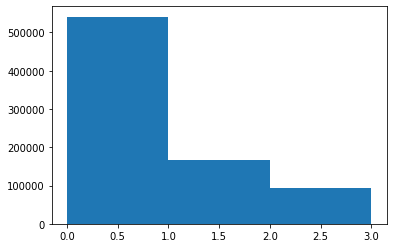

In [6]:
# tmp = train_set_df.label.hist(bins = [0,1,2,3])
tmp = plt.hist(y_train_raw, bins =  [0,1,2,3] )

In [7]:
tmp

(array([541030., 165984.,  92985.]),
 array([0, 1, 2, 3]),
 <a list of 3 Patch objects>)

In [8]:
tmp[0]/sum(tmp[0])

array([0.67628835, 0.20748026, 0.1162314 ])

**The labels are attributes of patients, not of specific samples (all patient's samples have the same label )** 

In [9]:
inds_0 = y_train_raw==0
inds_1 = y_train_raw==1
inds_2 = y_train_raw==2

In [10]:
patiends_0_set = set(train_set_df[inds_0]['patient_id'])
patiends_1_set = set(train_set_df[inds_1]['patient_id'])
patiends_2_set = set(train_set_df[inds_2]['patient_id'])

In [11]:
patiends_0_set.intersection(patiends_1_set)

set()

In [12]:
patiends_0_set.intersection(patiends_2_set)

set()

In [13]:
patiends_1_set.intersection(patiends_2_set)

set()

**Each patient's data consists of 3 time series. The number of samples in these series across the patients varies between 1 (single sample) and nearly 100**

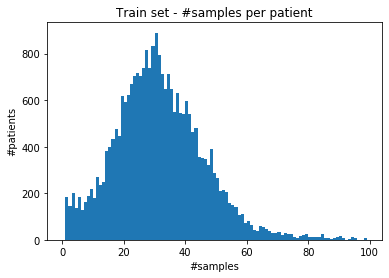

In [14]:
train_set_samples_sizes = [len(pdf[1]) for pdf in train_set_grouped_by_patients]
plt.hist(train_set_samples_sizes, bins = np.arange(0,100));
plt.title("Train set - #samples per patient");
plt.xlabel("#samples");
plt.ylabel("#patients");

**The test set has similar distribution, which means, in particular, that we'll need to predict labels of series consisting of a single time sample**

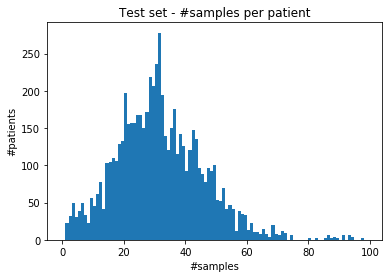

In [15]:
test_set_samples_sizes = [len(pdf[1]) for pdf in test_set_df.groupby('patient_id')]
plt.hist(test_set_samples_sizes, bins = np.arange(0,100));
plt.title("Test set - #samples per patient");
plt.xlabel("#samples");
plt.ylabel("#patients");

**Since the timedelta between each sample is 50ms, the corresponding series durations vary between 0 sec (single sample) to nearly 5 sec (100 samples)** 

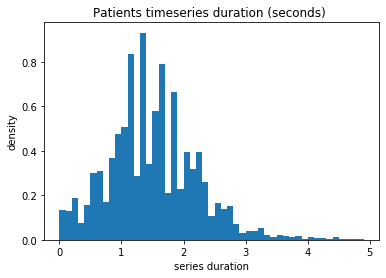

In [16]:
train_set_samples_durations = [(pdf[1]['timestamp'].iloc[-1] - pdf[1]['timestamp'].iloc[0]).total_seconds() for pdf in train_set_grouped_by_patients]
plt.hist(train_set_samples_durations, density=True, bins = np.arange(0, 5, 0.1));
plt.title("Patients timeseries duration (seconds) ");
plt.xlabel("series duration");
plt.ylabel("density");

**Some series are inconsistent in terms of their sizes and durations. Below we see some series with 5 samples (corresponding to 0.2 sec), whose duration is less than 0.2 sec** 

In [17]:
np.array(train_set_samples_durations)[np.array(train_set_samples_sizes)==5]

array([0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.15, 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.15, 0.15,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.15, 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.15, 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.15, 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.  , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.15, 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.

**Let's find the one with duration 0**

In [18]:
np.argmax((np.array(train_set_samples_sizes)==5) & (np.array(train_set_samples_durations) < 0.05))

18186

In [19]:
train_set_grouped_by_patients.get_group(18186)

,_temporary_index_column,patient_id,timestamp,measurement_x,measurement_y,measurement_z,label
566557,566558,18186,2015-01-02 09:08:28.683331,0.925543,-0.028669,0.097464,1
566558,566559,18186,2015-01-02 09:08:28.683331,0.928349,-0.038518,0.101493,1
566559,566560,18186,2015-01-02 09:08:28.683331,0.931236,-0.048345,0.104182,1
566560,566561,18186,2015-01-02 09:08:28.683331,0.934203,-0.058147,0.107254,1
566561,566562,18186,2015-01-02 09:08:28.683331,0.937251,-0.067925,0.110500,1


**Seems that the samples behave properly (they are not constant), so it seems like a bug in the timestamps registration. We can either remove such samples as outliers or fix their timestamps based on their number of samples**

**Here's another example:**

In [20]:
train_set_grouped_by_patients.get_group(np.argmax((np.array(train_set_samples_sizes)==5) & (np.array(train_set_samples_durations) == 0.1)))

,_temporary_index_column,patient_id,timestamp,measurement_x,measurement_y,measurement_z,label
691313,691314,22201,2013-08-20 16:42:45.478373,0.934248,0.226638,0.053605,1
691314,691315,22201,2013-08-20 16:42:45.478373,0.937080,0.233343,0.057909,1
691315,691316,22201,2013-08-20 16:42:45.578373,0.939844,0.240076,0.058216,1
691316,691317,22201,2013-08-20 16:42:45.578373,0.942538,0.246837,0.060546,1
691317,691318,22201,2013-08-20 16:42:45.578373,0.945163,0.253626,0.064965,1



## TimeSeries - acquaintance 

Since the class is a property of the patient, let's examine the per-patient classes. The classes proportions remain the same as when counting the raw samples. 

there are 25706 patients altogether


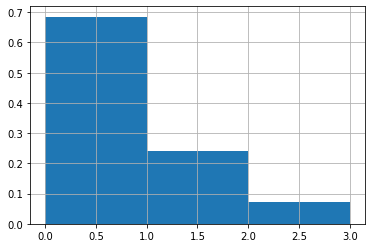

In [12]:
patients_classes_df = train_set_grouped_by_patients.nth(0)['label']
print(f"there are {len(patients_classes_df)} patients altogether")
patients_classes_df.hist(bins=[0,1,2,3], density=True);
y_per_patient = patients_classes_df.values

In [13]:
#Plot a patient timeseries, optionally with the regressed approximations superimposed (this comes later on)
def plot_patient_lines(patient_id, extracted_features = None, plot_ax = None):
    if plot_ax is None:
        fig_p, ax_p = plt.subplots()
    else:
        ax_p = plot_ax
    
    curr_patient_df = train_set_grouped_by_patients.get_group(patient_id)
    first_timestamp = curr_patient_df['timestamp'].iloc[0]
    curr_patient_df.index = list(map(lambda ts : (ts -first_timestamp).total_seconds()*1000, curr_patient_df['timestamp']))
    curr_patient_df[['measurement_x', 'measurement_y', 'measurement_z']].plot(ax=ax_p)
    if extracted_features is not None:
        coefs = extracted_features.reshape(3,3).T
        x_regr = curr_patient_df.index.values
        x_mat = np.array([np.ones(len(x_regr)), x_regr, x_regr*x_regr ]).T
        curr_patient_df_approx = pd.DataFrame( x_mat.dot(coefs), 
                                              columns = ['measurement_x_regr', 'measurement_y_regr', 'measurement_z_regr'], 
                                                index = curr_patient_df.index
                                             )
        curr_patient_df_approx[['measurement_x_regr', 'measurement_y_regr', 'measurement_z_regr']].plot(ax=ax_p, style='--')
    ax_p.set_title(f"Patient {patient_id} timeseries")
    ax_p.set_xlabel("time from first timestamp (ms)")
    return len(curr_patient_df), ax_p

#Choose n_patient random patients of class patient_class
def choose_rand_patients( n_patients, patient_class ):
    if patient_class not in [0,1,2]:
        raise Exception("Specified patient_class is not in existing classes set: [0,1,2]")
    patient_class_inds = y_per_patient==patient_class
    num_class_patients = sum(patient_class_inds)
    if n_patients > num_class_patients:
        raise Exception("Specified num samples {} exceeds the number of patients of requested class {}".format(n_patients, patient_class))
    selected_class_inds = random.sample(range(0, num_class_patients), n_patients)
    selected_patients = patients_classes_df[patient_class_inds].index[selected_class_inds]
    return selected_patients.values



**Let's view some timeseries of each of the classes**

(54, <matplotlib.axes._subplots.AxesSubplot at 0x2604e47508>)

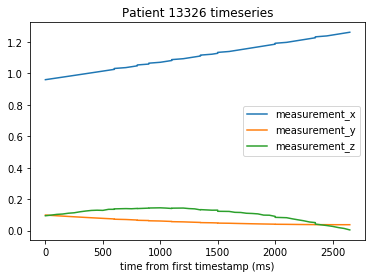

In [23]:
patients_ids = choose_rand_patients(1,1)

plot_patient_lines(patients_ids[0])

**Typical and less typical classes timeseries**

Based on sproradic visual inspection of the timelines. Left images are the more typical, right ones seems less typical to each class.  

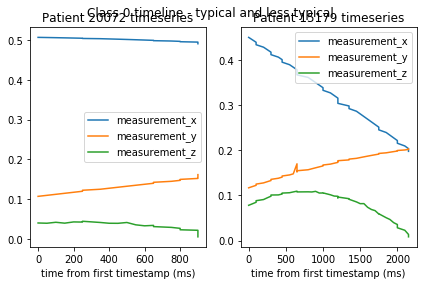

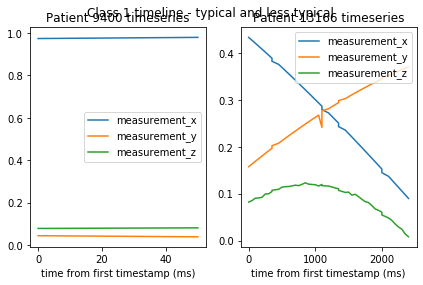

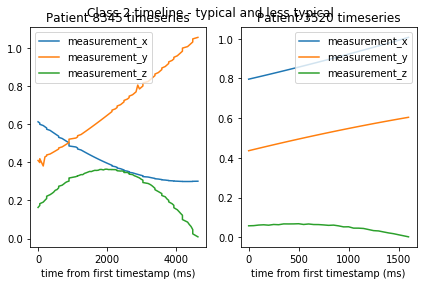

In [14]:
# plt.rcParams['figure.figsize'] = [12, 3]
fig_0, (ax_0_typical, ax_0_non_typical) = plt.subplots(1,2)
plot_patient_lines(20072, plot_ax=ax_0_typical)
plot_patient_lines(15179, plot_ax=ax_0_non_typical)
fig_0.suptitle("Class 0 timeline - typical and less typical \n")
plt.tight_layout()

fig_1, (ax_1_typical, ax_1_non_typical) = plt.subplots(1,2)
plot_patient_lines(9400, plot_ax=ax_1_typical)
plot_patient_lines(13166, plot_ax=ax_1_non_typical)
fig_1.suptitle("Class 1 timeline - typical and less typical \n")
plt.tight_layout()


fig_2, (ax_2_typical, ax_2_non_typical) = plt.subplots(1,2)
fig_2.suptitle("Class 2 timeline - typical and less typical \n")
plot_patient_lines(8345, plot_ax=ax_2_typical)
plot_patient_lines(3520, plot_ax=ax_2_non_typical) 
plt.tight_layout()


**Intermediate summary**

- Each patient is characterized by his/her 3 timeseries.  
- Visual inspection indicates that each class has a typical footprint in terms of its signals and their mutual configuration.
- A reasonable direction would be to represent each signal as a 1st or 2nd order polynomial, and use the coefficient as the features set for each patient.
- We can possibly add more features - e.g. whether or not signals intersect (typical to class 2), the average distance between signals (typically the y and z signals in class 1 are close)

# Features engineering

In [15]:
#Possible additional schemes: whether or not the x and y signals interserct. 
extraction_schemes = ['parabola']

def extract_signals_params(signals_df, extraction_scheme):
   
    timestamps = signals_df.loc[:, 'timestamp']
   
    first_timestamp =  timestamps.iloc[0]
    x = np.array(list(map(lambda ts : (ts -first_timestamp).total_seconds()*1000, timestamps)))
    x = np.array([x, x*x]).T #When the extraction_schemt is 'parabole', actually.
    sigs =  signals_df.loc[:, ['measurement_x', 'measurement_y', 'measurement_z']].values
    #Regress each signal to a 2nd order polynomial
    reg = LinearRegression().fit(x, sigs )
    #Add the initial value of each signal, and flatten to a single list.
    #Explicitly adding the intial value is redundant, since x starts at 0, hence the intercept is just this initial value
    return list(np.concatenate((np.array([reg.intercept_]).T, reg.coef_), axis=1).reshape(1,-1)[0])
    
    
def extract_single_patient_features( patient_df, extraction_scheme ):
    patient_id = patient_df['patient_id'].iloc[0]
    patient_features = []
    curr_line_params = extract_signals_params(patient_df, extraction_scheme)
    patient_features += curr_line_params
    return patient_features
        
    
def extract_features(in_df, extraction_scheme='parabola'):
    #TODO: input sanity checks
    X = []
    y = []
    for _,patient_df in in_df.groupby('patient_id'):
        extracted_features = extract_single_patient_features( patient_df, extraction_scheme )
        X.append(extracted_features )
        if 'label' in patient_df:
            y.append(patient_df['label'].iloc[0])
    return np.array(X), np.array(y)





In [16]:
X, y = extract_features(train_set_df)
X_t, _ = extract_features(test_set_df)

Let's check how well this model encodes the timeseries

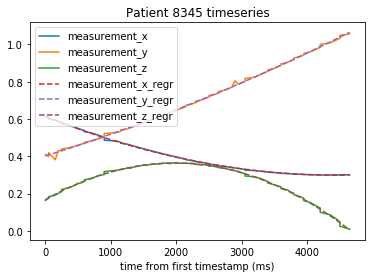

In [17]:
plot_patient_lines(8345, X[8345,:]);

Plot $X|y$, just to get a feeling of how well the features are seperable.

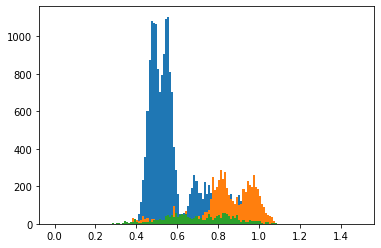

In [31]:
x_0 = X[ y==0, :]
x_1 = X[ y==1, :]
x_2 = X[ y==2, :]
# len(x_0)
fig_x_given_y, ax_x_given_y = plt.subplots()
bins_f8 = np.arange(-0.0000001, 0.00000001, 0.000000001)
bins_f0 = np.arange(0, 1.5, 0.01)
bins_f2 = np.arange(-0.00000004, 0.00000004, 0.000000001)
bins_f3 = np.arange(-0.2, 0.6, 0.01)
ax_x_given_y.hist(x_0[:,0], bins=bins_f0);
ax_x_given_y.hist(x_1[:,0], bins=bins_f0);
ax_x_given_y.hist(x_2[:,0], bins=bins_f0);



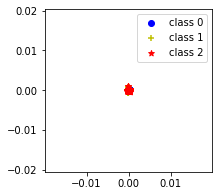

In [32]:
# %matplotlib qt
plt.rcParams['figure.figsize'] = [3, 3]
i=1
j=4
fig_x_given_y_2d, ax_x_given_y_3d = plt.subplots()
x_0_2_features = zip(x_0[:,i], x_0[:,j])
ax_x_given_y_3d.scatter(x_0[:,i], x_0[:,j], c='b', label='class 0')
ax_x_given_y_3d.scatter(x_1[:,i], x_1[:,j], c='y', marker='+', label='class 1')
ax_x_given_y_3d.scatter(x_2[:,i], x_2[:,j], c='r', marker='*', label='class 2')
plt.legend()
#     ax.scatter(X_1[:,0], X_1[:,1], c='b')


In [ ]:
np.argmax(X[:,3]<0 )

In [ ]:
X[0,:]

In [ ]:
X[0,:].reshape(3,3)

In [ ]:
len_patient_df, ax_patient_df = plot_patient_lines(90, X[90,:]);
# x_test = np.arange(0, len_patient_df)
# ax_patient_df.plot(x_test, X[0,0] + X[0,1]*x_test + X[0,2]*x_test*x_test, 'k+')

In [ ]:
len(X)

# Classification

In [44]:
X_train, X_test, y_train, y_test, inds_train, inds_test = train_test_split(X, y, np.arange(len(y)), test_size = 0.2)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
############################## Logistic Regression ########################

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_logit = scaler.transform(X_train)
# X_logit_test = scaler.transform(X_test)
clf = LogisticRegressionCV(cv=5, random_state=4, max_iter = 1000).fit(X_train_scaled, y_train)
y_hat = clf.predict(X_test_scaled)
# X_test_predicted_0 = X_test[y_hat==0]
# X_test_predicted_1 = X_test[y_hat==1]
# plt.scatter(X_test_predicted_0[:,0], X_test_predicted_0[:,1], c='y')
# plt.scatter(X_test_predicted_1[:,0], X_test_predicted_1[:,1], c='b')

cnf_matrix = confusion_matrix(y_test, y_hat, labels=[0, 1, 2])
print(cnf_matrix.T)
print(classification_report(y_test, y_hat))

In [ ]:
len(X_train_scaled)

In [ ]:
#################### SVM ####################
from sklearn.svm import SVC
from IPython.core.debugger import set_trace
# SVM with gaussian kernel


from sklearn.model_selection import GridSearchCV
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30],
                     'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]},
                    {'kernel': ['linear'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]}]



scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
       SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train_scaled, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print(classification_report(y_true, y_pred))
    print()

In [102]:
#################### SVM ####################
from sklearn.svm import SVC
from IPython.core.debugger import set_trace
# SVM with gaussian kernel


from sklearn.model_selection import GridSearchCV
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [  1],
                     'C': [300, 500, 800, 1000, 1500]}
                    ]



scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
       SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train_scaled, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred, labels=[0,1,2]).T)
    print()

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.984 (+/-0.005) for {'C': 300, 'gamma': 1, 'kernel': 'rbf'}
0.984 (+/-0.006) for {'C': 500, 'gamma': 1, 'kernel': 'rbf'}
0.984 (+/-0.005) for {'C': 800, 'gamma': 1, 'kernel': 'rbf'}
0.984 (+/-0.006) for {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
0.984 (+/-0.005) for {'C': 1500, 'gamma': 1, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3574
           1       0.99      0.99      0.99      1226
           2       1.00      0.98      0.99       342

    accuracy                           0.99      5142
   macro avg       0.99      0.99      0.99      5142
weighted avg       0.99      0.99      0.99      5142

[[3564   18    2]
 

In [121]:
X_train_scaled.shape

(20564, 9)

In [103]:
336/(342)

0.9824561403508771

In [81]:
print(confusion_matrix(y_true, y_pred).T)

[[3491   13    0]
 [  12 1252    5]
 [   0    0  369]]


In [82]:
[ i for i,val in enumerate((y_true == 2) & (y_pred == 1)) if val]

[554, 892, 1194, 3037, 4470]

In [93]:
inds_test[1194]

24602

(60, <matplotlib.axes._subplots.AxesSubplot at 0x26166c5ec8>)

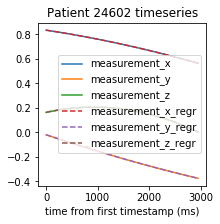

In [94]:
X_test[240,:]
plot_patient_lines(24602, X[24602,:] )

## More classifiers

In [23]:
# classifiers = {
#     "LogisiticRegression": LogisticRegression(),
#     "KNearest": KNeighborsClassifier(),
#     "Support Vector Classifier": SVC(),
#     "DecisionTreeClassifier": DecisionTreeClassifier()
# }

tuned_parameters = [{  'n_neighbors': [2, 3, 4]}
                    ]



scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
       KNeighborsClassifier(), tuned_parameters, scoring='%s_macro' % score, cv=7
    )
    clf.fit(X_train_scaled, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred, labels=[0,1,2]).T)
    print()

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.966 (+/-0.007) for {'n_neighbors': 2}
0.959 (+/-0.009) for {'n_neighbors': 3}
0.931 (+/-0.022) for {'n_neighbors': 4}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3563
           1       0.97      0.97      0.97      1205
           2       0.98      0.91      0.94       374

    accuracy                           0.99      5142
   macro avg       0.98      0.96      0.97      5142
weighted avg       0.99      0.99      0.99      5142

[[3556   25    5]
 [   7 1174   30]
 [   0    6  339]]



In [65]:
tuned_parameters = [{  'max_depth': [ 10, 20, 30, 40, 50, 60], 
                       'class_weight' :['balanced']
                    }
                    ]



scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
       DecisionTreeClassifier(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train_scaled, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred, labels=[0,1,2]).T)
    print()

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'class_weight': 'balanced', 'max_depth': 50}

Grid scores on development set:

0.935 (+/-0.009) for {'class_weight': 'balanced', 'max_depth': 10}
0.960 (+/-0.007) for {'class_weight': 'balanced', 'max_depth': 20}
0.961 (+/-0.006) for {'class_weight': 'balanced', 'max_depth': 30}
0.961 (+/-0.006) for {'class_weight': 'balanced', 'max_depth': 40}
0.962 (+/-0.003) for {'class_weight': 'balanced', 'max_depth': 50}
0.962 (+/-0.005) for {'class_weight': 'balanced', 'max_depth': 60}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3491
           1       0.97      0.96      0.96      1251
           2       0.95      0.95      0.95       400

    accuracy                           0.98      5142
   macro avg       0.97     

In [67]:
tuned_parameters = [{  'max_depth': [ 4,5, 6, 10, 20, 30, 40, 50, 60], 
                       'class_weight' :['balanced']
                    }
                    ]



scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
       DecisionTreeClassifier(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_scaled, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
#     y_true, y_pred = y_test, clf.predict(X_test_scaled)
#     print(classification_report(y_true, y_pred))
#     print(confusion_matrix(y_true, y_pred, labels=[0,1,2]).T)
#     print()

# clf.fit(, y)

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'class_weight': 'balanced', 'max_depth': 10}

Grid scores on development set:

0.737 (+/-0.089) for {'class_weight': 'balanced', 'max_depth': 4}
0.795 (+/-0.062) for {'class_weight': 'balanced', 'max_depth': 5}
0.841 (+/-0.072) for {'class_weight': 'balanced', 'max_depth': 6}
0.878 (+/-0.038) for {'class_weight': 'balanced', 'max_depth': 10}
0.874 (+/-0.037) for {'class_weight': 'balanced', 'max_depth': 20}
0.875 (+/-0.033) for {'class_weight': 'balanced', 'max_depth': 30}
0.873 (+/-0.033) for {'class_weight': 'balanced', 'max_depth': 40}
0.877 (+/-0.033) for {'class_weight': 'balanced', 'max_depth': 50}
0.875 (+/-0.035) for {'class_weight': 'balanced', 'max_depth': 60}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



In [26]:
dfcv = pd.DataFrame(clf.cv_results_)
dfcv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,0.050183,0.004455,0.284960,0.013753,2,{'n_neighbors': 2},0.966726,0.963912,0.966025,0.962688,0.969723,0.959696,0.971299,0.965724,0.003722,1
1,0.048885,0.000634,0.388589,0.017650,3,{'n_neighbors': 3},0.958121,0.959660,0.963305,0.952734,0.963531,0.951671,0.961462,0.958641,0.004447,2
2,0.048608,0.000724,0.448460,0.024227,4,{'n_neighbors': 4},0.944256,0.932865,0.944289,0.912658,0.931230,0.918653,0.934170,0.931160,0.011049,3


In [29]:
dfcv[["split{}_test_score".format(j) for j in range(7)]].mean(axis=1)

0    0.965724
1    0.958641
2    0.931160
dtype: float64

# Submission

**Use the entire training set to train the submission classifier**

In [137]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_t)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30],
                     'C': [1, 30, 100 ,300, 500, 800, 1000, 1500]}
                   ]
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    clf = GridSearchCV(
       SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_scaled, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    
# Now apply on provided test set.
y_test_hat = clf.predict(X_test_scaled)
res_df = pd.DataFrame( { 'label' : y_test_hat, 'patient_id' : test_set_df.groupby('patient_id').nth(0).index.values})
res_df.to_csv("clew_assignment_submission_matan.csv")

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.03, 'kernel': 'rbf'}

Grid scores on development set:

0.856 (+/-0.039) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.868 (+/-0.037) for {'C': 1, 'gamma': 0.03, 'kernel': 'rbf'}
0.880 (+/-0.033) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.890 (+/-0.027) for {'C': 1, 'gamma': 0.3, 'kernel': 'rbf'}
0.866 (+/-0.033) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.791 (+/-0.027) for {'C': 1, 'gamma': 3, 'kernel': 'rbf'}
0.530 (+/-0.027) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.298 (+/-0.012) for {'C': 1, 'gamma': 30, 'kernel': 'rbf'}
0.878 (+/-0.027) for {'C': 30, 'gamma': 0.01, 'kernel': 'rbf'}
0.903 (+/-0.027) for {'C': 30, 'gamma': 0.03, 'kernel': 'rbf'}
0.920 (+/-0.027) for {'C': 30, 'gamma': 0.1, 'kernel': 'rbf'}
0.907 (+/-0.032) for {'C': 30, 'gamma': 0.3, 'kernel': 'rbf'}
0.850 (+/-0.032) for {'C': 30, 'gamma': 1, 'kernel': 'rbf'}
0.781 (+/-0.022) for {'C': 30, 'gamma': 3, 'ker

In [42]:
clf_svc_partial_train = SVC(C=1000, kernel='rbf', gamma=1)
clf_svc_full_train = SVC(C=1000, kernel='rbf', gamma=0.03)
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_test_raw_scaled = scaler.transform(X_t)

In [69]:
clf_svc_partial_train.fit(X_train_scaled, y_train)
y_hat_partial = clf_svc_partial_train.predict(X_test_scaled)

In [70]:
print(classification_report(y_test, y_hat_partial))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3491
           1       0.98      0.99      0.99      1251
           2       1.00      0.99      0.99       400

    accuracy                           0.99      5142
   macro avg       0.99      0.99      0.99      5142
weighted avg       0.99      0.99      0.99      5142



In [71]:
clf_svc_full_train.fit(X_scaled, y)
y_hat_full = clf_svc_full_train.predict(X_test_scaled)

In [72]:
print(classification_report(y_test, y_hat_full))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3491
           1       0.93      0.91      0.92      1251
           2       0.99      0.98      0.99       400

    accuracy                           0.96      5142
   macro avg       0.96      0.96      0.96      5142
weighted avg       0.96      0.96      0.96      5142



In [134]:
test_set_df.groupby('patient_id').nth(0).index

Int64Index([25705, 25706, 25707, 25708, 25709, 25710, 25711, 25712, 25713,
            25714,
            ...
            32046, 32047, 32048, 32049, 32050, 32051, 32052, 32053, 32054,
            32055],
           dtype='int64', name='patient_id', length=6351)

In [136]:
res_df = pd.DataFrame( { 'label' : y_test_hat, 'patient_id' : test_set_df.groupby('patient_id').nth(0).index.values})
res_df.to_csv("clew_assignment_submission_matan.csv")

In [89]:
np.unique(y_pred)

array([0, 1, 2], dtype=int64)

In [90]:
y_true_binary = y_true
y_true_binary[y_true_binary == 1] = 0
y_true_binary[y_true_binary == 2] = 1
np.unique(y_true_binary)
print(np.unique(y_true))
y_pred_binary = y_pred
y_pred_binary[y_pred_binary == 1] = 0
y_pred_binary[y_pred_binary == 2] = 1
np.unique(y_pred_binary)
all((y_pred_binary==1) == (y_pred == 2))
# sklearn.metrics.f1_score(y_true_binary, y_pred_binary) 
print(classification_report(y_true_binary, y_pred_binary))
print(confusion_matrix(y_true_binary, y_pred_binary, labels=[0, 1]).T)
print(confusion_matrix(y_true, y_pred, labels=[0, 1,2]).T)

[0 1]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4768
           1       1.00      0.99      0.99       374

    accuracy                           1.00      5142
   macro avg       1.00      0.99      1.00      5142
weighted avg       1.00      1.00      1.00      5142

[[4768    5]
 [   0  369]]
[[4768    5    0]
 [   0  369    0]
 [   0    0    0]]


In [92]:
np.unique(y_true)

array([0, 1], dtype=int64)

TODO:
* Weigh signals based on their duration (a signal of 4 timestamps is less indicative than a 30 samples one). Additionally - apply classification on only the subset of signals with more than M timestamp and show scores over this set. 
* More features: do lines intersect? what's the average distane between two lines?
* Beautify code: add parameters types, sanity tests and comments, remove debug printouts.
* Add ROC
* If possible - use these fancy auto analysis pandas tools.

Theoretical:
* squared v.s. abs regularization
* Trees v.s. LR v.s. SVM - which one will be better under which circumstances? 

In [ ]:
from sklearn.linear_model import LinearRegression
patient_df = train_set_df[train_set_df['patient_id'] == 0 ]

x = np.arange(0,len(patient_df))*50
plt.plot(x, patient_df.loc[:,[ 'measurement_x', 'measurement_y', 'measurement_z']])
xx = np.array([x, x*x]).T
examined_sig = patient_df.loc[:,[ 'measurement_x', 'measurement_y', 'measurement_z']].values
# print(xx)
reg = LinearRegression().fit(xx, examined_sig )
print(reg.coef_)
print( reg.intercept_)
plt.plot(x, reg.intercept_[0] + reg.coef_[0][0]*x + reg.coef_[0][1]*x*x, '+')
plt.plot(x, reg.intercept_[1] + reg.coef_[1][0]*x + reg.coef_[1][1]*x*x, '+')
plt.plot(x, reg.intercept_[2] + reg.coef_[2][0]*x + reg.coef_[2][1]*x*x, '+')

Interesting examples:
* 15175, 15176 - two examples of 2 class which are quite different
* 15178, 15179 - two examples of 0 class which seem identical, and also typical to type 2 class. More typical 0 ones: 1903


In [ ]:
plot_patient_lines(15175)

In [ ]:
print(examined_sig[1,:])
print(np.concatenate((np.array([examined_sig[1,:], reg.intercept_]).T, reg.coef_), axis=1))
print(list(np.concatenate((np.array([examined_sig[1,:], reg.intercept_]).T, reg.coef_), axis=1).reshape(1,-1)[0]))

In [ ]:
tmp = []
tmp.append([1,2,3])
tmp.append([4,5,6])
print(np.array(tmp))

In [ ]:
tmp = [1]
tmp += [4,5,6]
tmp

In [ ]:
np.array(list(map(lambda x : x*x, [1,2,3])))

In [ ]:
patients_grouped = train_set_df.groupby('patient_id')
patients_grouped.first()

In [ ]:
df = pd.DataFrame()

In [ ]:
df = pd.DataFrame(np.array([[1,2,3],[4,5,6]]).T, columns=['a','b'])

In [ ]:
np.argmax(np.array([0,0,1,1,0]))

In [30]:
plt.rcParams['figure.figsize']

[6.0, 4.0]

In [96]:
y_true_fab = [ 0,0,0,0,0,0,0,0, 1,1,1, 1, 2, 2, 2]
y_hat_fab = [ 0,0,0,0,0,0,1,2, 1,1,0, 2, 1, 2, 2]
print(classification_report(y_true_fab, y_hat_fab, labels=[0,1,2]))
print(confusion_matrix(y_true_fab, y_hat_fab).T)

              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.50      0.50      0.50         4
           2       0.50      0.67      0.57         3

    accuracy                           0.67        15
   macro avg       0.62      0.64      0.62        15
weighted avg       0.69      0.67      0.67        15

[[6 1 0]
 [1 2 1]
 [1 1 2]]


In [100]:
6/7

0.8571428571428571